<a href="https://colab.research.google.com/github/channnnsm/causal-inference-study/blob/main/chap3_2_propensity_score_matching_IPW_%E5%82%BE%E5%90%91%E3%82%B9%E3%82%B3%E3%82%A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 傾向スコア

## 共変量調整
*   共変量が多いと多重共線性が発生しやすい
*   そこで、共変量を調整して比較対象同士をより近いものにする
*   交絡因子Cを用いてCからYへの影響を最小限に抑える
*   その関数をバランシングスコアという
*   バランシングスコアを使って処置群と対照群の交絡因子を調整する
*   このバランシングスコアの一つとして、傾向スコアがある














## 傾向スコア
*   未観測の交絡因子が存在しない場合、交絡因子Cで条件づけた処置確率(処置群に属する確率)として以下の式で定義される
*   $ 0 < π(C) < 1 $    
*   例：新薬の臨床試験で交絡因子Cが与えられたとき、新薬が与えられる(T=1)確率が傾向スコアπ(C)に該当する
*   $ π(C) = P(T=1|C) $
*   このとき、傾向スコアはTを目的変数とした回帰モデルを用いて計算される
*   例：傾向スコアの推定に、ロジスティック回帰モデルや機械学習モデルの勾配ブースティングなどを使う
*   傾向スコアを使用することで、多次元の交絡因子を一次元の指標に変換できる
*   例：$ C_1:年齢, C_2:血圧, C_n:運動量, →π(C) $
*   そして、π(C)の傾向スコアが近い対象同士の因果効果を推定する

In [1]:
!pip install causallib==0.9.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires

In [2]:
from causallib.datasets import load_nhefs
from causallib.estimation import IPW, PropensityMatching,StratifiedStandardization
from causallib.evaluation import evaluate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [3]:
data = load_nhefs()

# 1.傾向スコアマッチング

*   処置群と対照群において、共変量の値が近いもの同士を組み合わせる手法のこと
*   因果効果推定時に使用するデータは**マッチングしたデータのみ**



In [4]:
#傾向スコアを算出するモデルの定義
learner = LogisticRegression(
solver="liblinear", # liblinear: 線形モデル向けの最適化アルゴリズム
class_weight="balanced") # 正例と負例のバランスを取るために使用（第4章で説明）

#傾向スコアの算出とマッチング
pm = PropensityMatching(learner=learner)
pm.fit(data.X, data.a, data.y)

PropensityMatching(caliper=None, covariance_conditioner=EmpiricalCovariance(), estimate_observed_outcome=False, knn_backend=sklearn, matching_mode=both, metric=mahalanobis, n_neighbors=1, propensity_transform=PropensityTransformer(learner=LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')), with_replacement=True,
                   learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [5]:
# ATEの計算
outcomes = pm.estimate_population_outcome(data.X, data.a) # 処置群と対照群それぞれの結果変数の平均値を推定
effect = pm.estimate_effect(outcomes[1],outcomes[0])# ATEを推定

#結果の出力
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
print(f"Average outcome of Treated: {outcomes[1]:.3f}")
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.726
Average outcome of Treated: 4.683
Average Treatment Effect: 2.956


# 2.Inverse Probability Weighting: IPW (逆確率重みづけ)

*   観測データの各個体に適切な重みを割り当てることで、処置群と対照群の分布が似ている疑似母集団を形成する
*   重み付けは傾向スコアを用いて行う
*   逆確率重み付けでは、処置群には傾向スコアの逆数で重み付けを行い、対照群には(1-傾向スコア)の逆数で重み付けをする



In [6]:
#傾向スコアを算出するモデルの定義
learner = LogisticRegression(
solver="liblinear",
class_weight="balanced")

#傾向スコアを算出し、IPWを実施
ipw = IPW(learner = learner)
ipw.fit(data.X, data.a)

# ATEの計算
outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

#結果の出力
print(f"Average outcome of Untreated: {outcomes[0]:.3f}")
print(f"Average outcome of treated: {outcomes[1]:.3f}")
print(f'Average Treatment Effect: {effect["diff"]:.3f}')

Average outcome of Untreated: 1.563
Average outcome of treated: 4.975
Average Treatment Effect: 3.412


# 結果の評価方法

##   共変量や傾向スコアのバランスを評価する
*   傾向スコアはそもそも共変量を調整するための方法
*   各群の共変量や傾向スコアを比較する
*   共変量や傾向スコアのバランスがとれている必要があるのは、識別仮定の条件付き独立性および正値性を満たすため
*   各群において傾向スコアの重複が少ない場合は、フェアに比較ができない


##   1.絶対標準化平均差(Absolute Standardized Mean Difference: ASMD)
*   共変量のバランスを評価するための指標の一つが標準化平均差(Standardized Meam Difference:SMD)
*   標準化平均差(SMD)は、**各群における共変量の平均値の差分が小さいとき、かつ標準偏差が大きいときに、両群の共変量の分布の重なりは大きくなり、共変量の分布の差が小さくなる**
*   標準偏差が大きいときは、同じ平均値の差でもSMDが小さくなり、群間のバランスが良い(=分布が重なっている)
*   一方、標準偏差が小さいと、少しの平均値の差でもSMDが大きくなり、群間の違いが強調されてしまう
*   標準偏差が大きいと分布は広がり、標準偏差が小さいと分布が狭くなる

<Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

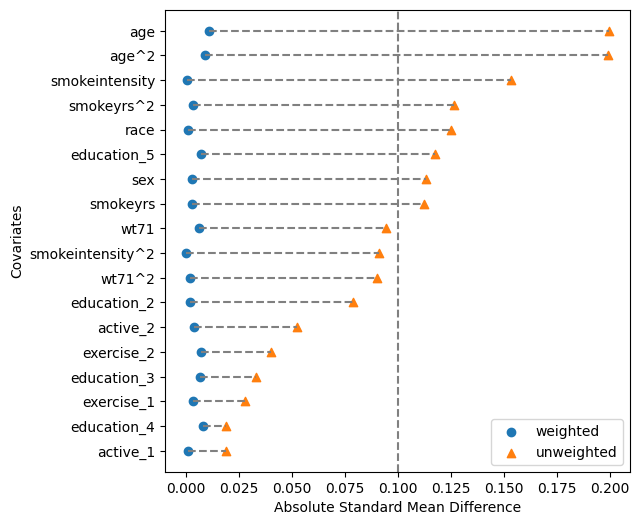

In [7]:
results = evaluate(ipw, data.X, data.a, data.y)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
results.plot_covariate_balance(kind="love", ax=ax, thresh=0.1) #ASMDのカットオフ値(thresh)を0.1に設定

##   2.分散比
*   共変量のバランスを評価するための指標のもう一つが処置群と対照群の共変量の分散比
*   共変量の分散比が1に近いほど許容可能なバランスであることを示す ※2未満であれば一般的には許容可能
*   $\text{分散比} = \frac{\text{処置群の分散}}{\text{対照群の分散}}
$

In [11]:
# 処置群と対照群を分ける
treated = data.X[data.a == 1]  # 処置群の共変量
untreated = data.X[data.a == 0]  # 対照群の共変量

# 各共変量の分散比を計算
import numpy as np

variance_ratios = {}
for column in data.X.columns:  # 共変量の各列
    treated_variance = np.var(treated[column], ddof=1)  # 処置群の不偏分散
    untreated_variance = np.var(untreated[column], ddof=1)  # 対照群の不偏分散
    variance_ratio = treated_variance / untreated_variance  # 分散比
    variance_ratios[column] = variance_ratio

# 分散比を出力
print("\nVariance Ratios:")
for covariate, ratio in variance_ratios.items():
    print(f"{covariate}: {ratio:.3f}")

# 分散比の基準範囲チェック（例: 0.8～1.25）
print("\nVariance Ratio Check (Acceptable range: 0.8 - 1.25):")
for covariate, ratio in variance_ratios.items():
    if 0.8 <= ratio <= 1.25:
        print(f"{covariate}: OK")
    else:
        print(f"{covariate}: OUTSIDE acceptable range")



Variance Ratios:
age: 1.073
race: 0.653
sex: 0.998
smokeintensity: 1.168
smokeyrs: 1.185
wt71: 1.061
active_1: 1.006
active_2: 1.220
education_2: 0.851
education_3: 0.983
education_4: 0.918
education_5: 1.463
exercise_1: 1.013
exercise_2: 1.027
age^2: 1.163
wt71^2: 1.088
smokeintensity^2: 1.152
smokeyrs^2: 1.328

Variance Ratio Check (Acceptable range: 0.8 - 1.25):
age: OK
race: OUTSIDE acceptable range
sex: OK
smokeintensity: OK
smokeyrs: OK
wt71: OK
active_1: OK
active_2: OK
education_2: OK
education_3: OK
education_4: OK
education_5: OUTSIDE acceptable range
exercise_1: OK
exercise_2: OK
age^2: OK
wt71^2: OK
smokeintensity^2: OK
smokeyrs^2: OUTSIDE acceptable range


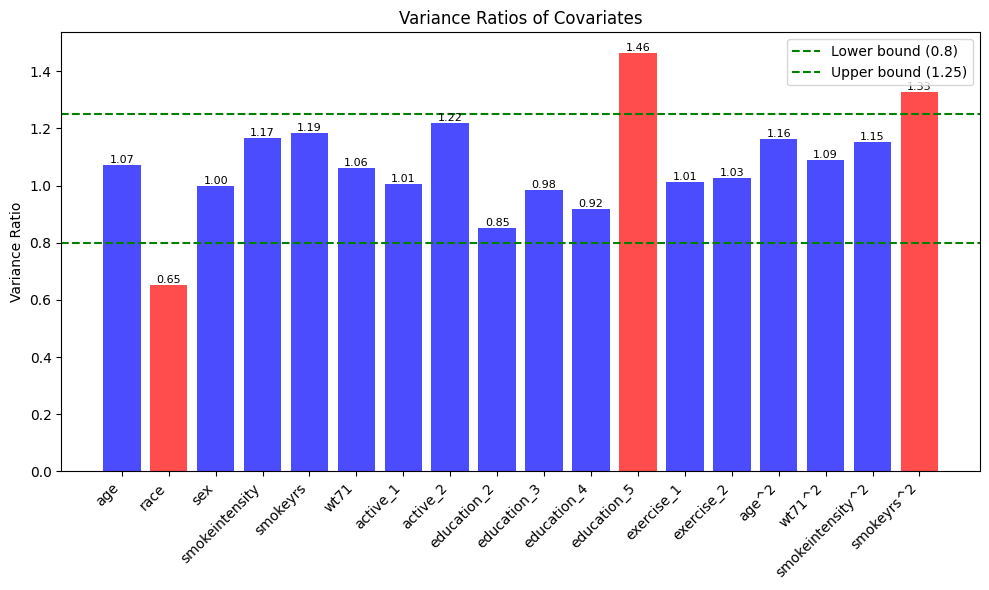

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 分散比のデータ（例: 先ほどの結果を使用）
variance_ratios = {
    "age": 1.073,
    "race": 0.653,
    "sex": 0.998,
    "smokeintensity": 1.168,
    "smokeyrs": 1.185,
    "wt71": 1.061,
    "active_1": 1.006,
    "active_2": 1.220,
    "education_2": 0.851,
    "education_3": 0.983,
    "education_4": 0.918,
    "education_5": 1.463,
    "exercise_1": 1.013,
    "exercise_2": 1.027,
    "age^2": 1.163,
    "wt71^2": 1.088,
    "smokeintensity^2": 1.152,
    "smokeyrs^2": 1.328
}

# 許容範囲
lower_bound = 0.8
upper_bound = 1.25

# グラフのデータ準備
variables = list(variance_ratios.keys())
values = list(variance_ratios.values())

# 色分け: 許容範囲内なら青、外なら赤
colors = ["blue" if lower_bound <= v <= upper_bound else "red" for v in values]

# 図の描画
plt.figure(figsize=(10, 6))
bars = plt.bar(variables, values, color=colors, alpha=0.7)

# 許容範囲を示すライン
plt.axhline(y=lower_bound, color="green", linestyle="--", label="Lower bound (0.8)")
plt.axhline(y=upper_bound, color="green", linestyle="--", label="Upper bound (1.25)")

# 軸とラベル
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variance Ratio")
plt.title("Variance Ratios of Covariates")
plt.legend()

# ラベルを追加（棒グラフの上に値を表示）
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.2f}",
             ha="center", va="bottom", fontsize=8)

# 図の表示
plt.tight_layout()
plt.show()


## 3.傾向スコアの分布を図示

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

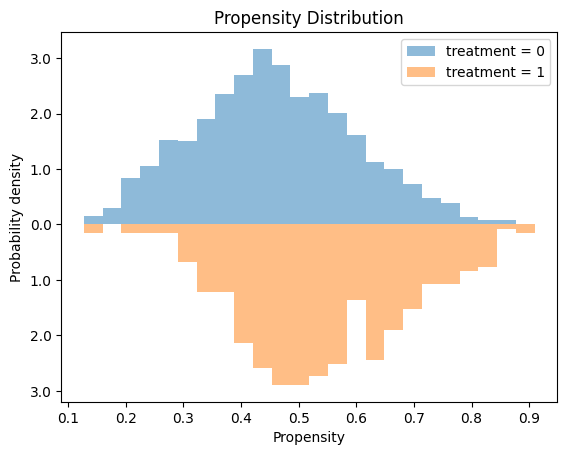

In [8]:
results.plot_weight_distribution()

# 傾向スコア分析の課題

## 未観測の交絡因子への対応

## IPWの極端な重み付けへの対応